# 1. LoRa Modulator / Demodulator

 <img src="docs/spectrogram.png">
 LoRa modulācijas galvnie parametri:
 
 - spread factor (SF)
 - bandwidth (BW)
 - carrier frequency (f0)
 
 
1 simbols = 1 chirps ar ciklisko nobīdi [-BW/2 +BW/2] = SF biti = $2^{SF}$ nolases (ar BW sample rate)

 <img src="docs/IQ.png">
 $$RF= I(t)\,cos(\omega_0t) + Q(t)\,sin(\omega_0t)$$

In [1]:
%pylab inline
import cmath
from numpy.fft import fft
from ipywidgets import *

SF = 7
N = 2 ** SF

Populating the interactive namespace from numpy and matplotlib


In [2]:
def modulate(N, sym):
    phase = -math.pi
    samps = []
    step = 2 * pi / N
    off = step * sym

    accum = 0
    for i in range(N):
        accum += phase + off
        samps.append(cmath.rect(1.0, accum))
        phase += step

    return array(samps)

In [3]:
def fmdemod(s):
    return angle(s[1:] * conj(s)[:-1])

In [4]:
IQ = modulate(N, 0)
I = real(IQ)
Q = imag(IQ)

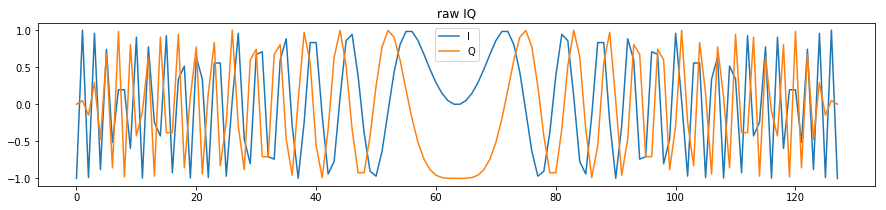

In [5]:
figure(figsize=(15, 3))
plot(I)
plot(Q)
legend(["I", "Q"])
_ = title("raw IQ")

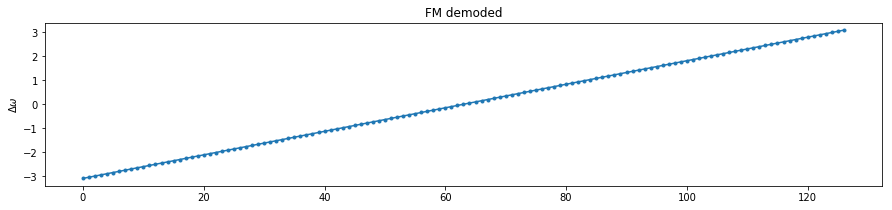

In [6]:
figure(figsize=(15, 3))
plot(fmdemod(IQ), ".-")
ylabel("$\Delta\omega$")
_ = title("FM demoded")

In [7]:
@interact(demod=False, sym=IntSlider(min=0, max=N-1, step=1, value=42, continuous_update=False))
def show(demod, sym):
    figure(figsize=(15, 10))
    subplot(3,1,1)

    IQ = modulate(N, sym)
    plot(fmdemod(IQ), ".-")
    ylabel("$\Delta\omega$")
    title("FM demoded (raw)")

    if demod:
        downchirp = conj(modulate(N, 0))
        plot(fmdemod(downchirp), ".-")

        subplot(3,1,2)
        prod = IQ * downchirp
        plot(fmdemod(prod), ".-")
        ylim([-4, 4])
        ylabel("$\Delta\omega$")       
        title("FM demoded (dechirped)")        
        
        subplot(3,1,3)  
        spec = abs(fft(prod))
        recovered = argmax(spec)
        plot(spec, ".-")
        plot(recovered, spec[recovered], 'xk', markersize=20)
        ylabel("fft")
        title(f"FFT bins, detected: {recovered}")
        return f"demodulation result: {recovered}"

interactive(children=(Checkbox(value=False, description='demod'), IntSlider(value=42, continuous_update=False,…

In [8]:
syms = [0, 0, 50, 75, 100]
chirps = concatenate([modulate(N, sym) for sym in syms])
chirps = concatenate([zeros(N), chirps, zeros(N)])

In [9]:
@interact(offset=IntSlider(min=-40, max=40, step=2, value=0, continuous_update=False))
def show(offset):
    figure(figsize=(15, 10))
    subplot(2,1,1)    
    plot(fmdemod(chirps))
    ylabel("$\Delta\omega$")      

    start = N + offset
    downchirp = conj(modulate(N, 0))

    # starts: indexes of every chunk start
    starts = list(range(start, len(chirps), N))
    chunks = split(chirps, starts)[1:-1]
    downchirp = conj(modulate(N, 0))
    
    for x in starts:
        axvline(x, c="r", ls="--")
    
    subplot(2,1,2)    
    for chunk in chunks:
        prod = chunk * downchirp
        spec = abs(fft(prod))   
        recovered = argmax(spec)
        print(recovered)
        plot(spec, ".", ms=20)
        ylabel("fft")

    legend(syms)
    for x in syms:
        axvline(x, c="k", ls=":")

interactive(children=(IntSlider(value=0, continuous_update=False, description='offset', max=40, min=-40, step=…

 # 2. Encoder / Decoder
 <img src="docs/coder.png">

- __Whitening__ : reizina bitu plusmu ar pseido-random virkni.
$(msg\oplus mask)\oplus mask=msg$


- (optional) __Header__: msg garums, kodēšanas parametri, __CRC__: kontrolsumma


- __Hamming(m,n) coding__:
    - (4, 5) parity
    - (4, 6) parity
    - (4, 7) single bit error correction
    - (4, 8) single bit error correction, double bit error detection


- __Interleaving__: scrambel bits within the frame


- __Gray indexing__: "_off-by-one error_" correction
